In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.features.extract_features import *
from src.data.dataset import *

In [4]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["figure.max_open_warning"] = False
data_files = glob.glob(r"D:\Hagar\Downloads\data\*\*")

In [5]:
# for file in data_files:
#     data = pd.read_csv(file)
    
#     ch1_mean = data.Channel1.mean()
#     ch2_mean = data.Channel2.mean()
#     data.Channel1 = data.Channel1.apply(lambda x: x - ch1_mean)
#     data.Channel2 = data.Channel2.apply(lambda x: x - ch2_mean)
    
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     subject = file.split("\\")[-2]
#     gesture = file.split("\\")[-1]
#     fig.suptitle(subject + gesture)
#     samples = np.arange(len(data.Channel1))
#     sns.lineplot(data = data, x=samples, y = "Channel1", hue = "Label", ax=ax1)
#     sns.lineplot(data = data, x=samples, y = "Channel2", hue = "Label", ax=ax2)

In [6]:
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from keras import Sequential, layers, initializers, optimizers, losses

data_dir = r"D:\Hagar\Downloads\data"

def generate_dataset(data_dir, feature_set, win_size, win_stride, is_td=True):
    dataset = EmgDataset(data_dir, win_size, win_stride, feature_set, is_td)
    
    emg_features = dataset.extracted_features
    labels = dataset.rolled_labels
    reps = dataset.rolled_repetition
    
    train_rows = np.isin(reps, ['1','3','4']).ravel()
    test_rows = np.isin(reps, ['2']).ravel()

    train_emg = emg_features[train_rows]
    y_train = labels[train_rows].ravel()

    test_emg = emg_features[test_rows]
    y_test = labels[test_rows].ravel()

    print(f"X_train shape: {train_emg.shape} y_train shape: {y_train.shape}")
    print(f"X_test shape: {test_emg.shape} y_test shape: {y_test.shape}")
    
    y_train = y_train[~np.isnan(train_emg).any(axis=1)]
    train_emg = train_emg[~np.isnan(train_emg).any(axis=1)]

    y_test = y_test[~np.isnan(test_emg).any(axis=1)]
    test_emg = test_emg[~np.isnan(test_emg).any(axis=1)]
    
    return train_emg, test_emg, y_train, y_test

def transform_dataset(train_emg, test_emg, y_train):
    undersampler = RandomUnderSampler(random_state=0)
    X_train_under, y_train_under = undersampler.fit_resample(train_emg, y_train)

    X_train, y_train = shuffle(X_train_under, y_train_under, random_state=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(test_emg)
    
    return X_train_scaled, X_test_scaled, y_train

def build_model():    
    model = Sequential()
    model.add(layers.Dense(512, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(6, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return model

def evaluate_model(y_test, predictions):
    acc = accuracy_score(y_test, predictions.argmax(axis=1))
    balanced_acc = balanced_accuracy_score(y_test, predictions.argmax(axis=1))
    return acc, balanced_acc

def plot_results(y_test, predictions):
    print(classification_report(y_test, predictions.argmax(axis=1)))
    cm = confusion_matrix(y_test, predictions.argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    disp.plot(ax=ax)
    plt.show()

In [7]:
win_size = 200
win_stride = 150

In [8]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [9]:
feature_sets = []
accuracies = []
balanced_accuracies = []

## DNN w/ RMS

In [10]:
feature_set = ["rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 2) y_train shape: (24200,)
X_test shape: (10557, 2) y_test shape: (10557,)


In [11]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 5ms/step - loss: 1.4107 - accuracy: 0.4996 - val_loss: 0.9721 - val_accuracy: 0.6701
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 1.2735 - accuracy: 0.5411 - val_loss: 0.9647 - val_accuracy: 0.6776
Epoch 3/30
387/387 [==============================] - 2s 5ms/step - loss: 1.2399 - accuracy: 0.5452 - val_loss: 0.9405 - val_accuracy: 0.6738
Epoch 4/30
387/387 [==============================] - 3s 7ms/step - loss: 1.2016 - accuracy: 0.5524 - val_loss: 0.9463 - val_accuracy: 0.6652
Epoch 5/30
387/387 [==============================] - 3s 7ms/step - loss: 1.1837 - accuracy: 0.5610 - val_loss: 0.9229 - val_accuracy: 0.6824
Epoch 6/30
387/387 [==============================] - 2s 5ms/step - loss: 1.1713 - accuracy: 0.5624 - val_loss: 0.9529 - val_accuracy: 0.6690
Epoch 7/30
387/387 [==============================] - 2s 6ms/step - loss: 1.1552 - accuracy: 0.5696 - val_loss: 0.9504 - val_accuracy: 0.6606
Epoch 

Test Accuracy: 0.6594676517950175 Balanced Test Accuracy: 0.6234662185865222
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      4913
           1       0.54      0.53      0.54      1229
           2       0.39      0.56      0.46      1003
           3       0.29      0.35      0.32      1066
           4       0.59      0.67      0.63      1082
           5       0.70      0.91      0.79      1264

    accuracy                           0.66     10557
   macro avg       0.57      0.62      0.59     10557
weighted avg       0.71      0.66      0.67     10557



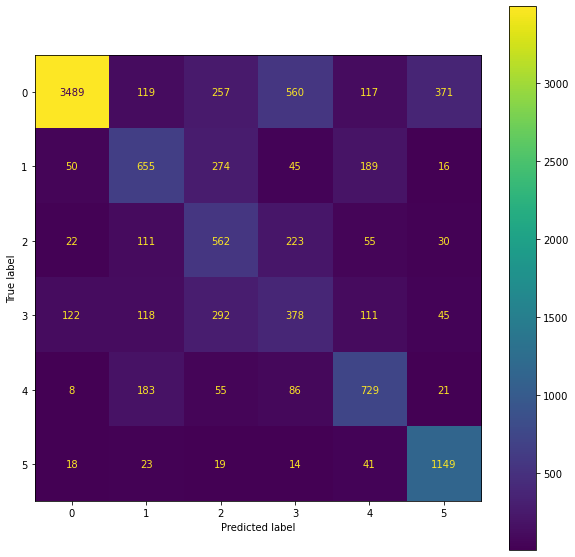

In [12]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [13]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms']] [0.6594676517950175] [0.6234662185865222]


## DNN w/ ZC/SSC/WL

In [14]:
feature_set = ["zc", "ssc", "wl"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 6) y_train shape: (24200,)
X_test shape: (10557, 6) y_test shape: (10557,)


In [15]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 6ms/step - loss: 1.1869 - accuracy: 0.5700 - val_loss: 0.7403 - val_accuracy: 0.7189
Epoch 2/30
387/387 [==============================] - 3s 7ms/step - loss: 1.0182 - accuracy: 0.6204 - val_loss: 0.7076 - val_accuracy: 0.7351
Epoch 3/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9705 - accuracy: 0.6307 - val_loss: 0.6882 - val_accuracy: 0.7368
Epoch 4/30
387/387 [==============================] - 3s 7ms/step - loss: 0.9609 - accuracy: 0.6295 - val_loss: 0.6871 - val_accuracy: 0.7373
Epoch 5/30
387/387 [==============================] - 3s 7ms/step - loss: 0.9521 - accuracy: 0.6305 - val_loss: 0.6868 - val_accuracy: 0.7403
Epoch 6/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9313 - accuracy: 0.6408 - val_loss: 0.7053 - val_accuracy: 0.7276
Epoch 7/30
387/387 [==============================] - 3s 7ms/step - loss: 0.9244 - accuracy: 0.6413 - val_loss: 0.7203 - val_accuracy: 0.7263
Epoch 

Test Accuracy: 0.7309841811120583 Balanced Test Accuracy: 0.6465196341355128
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4913
           1       0.55      0.56      0.55      1229
           2       0.36      0.50      0.42      1003
           3       0.32      0.26      0.29      1066
           4       0.65      0.74      0.69      1082
           5       0.93      0.95      0.94      1264

    accuracy                           0.73     10557
   macro avg       0.62      0.65      0.63     10557
weighted avg       0.75      0.73      0.74     10557



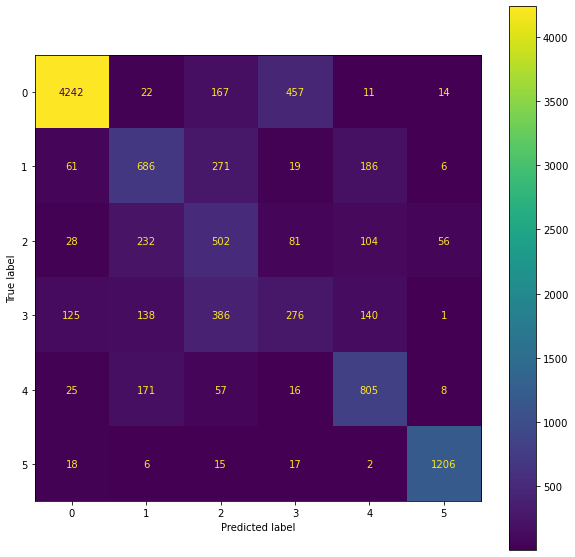

In [16]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [17]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl']] [0.6594676517950175, 0.7309841811120583] [0.6234662185865222, 0.6465196341355128]


## DNN w/ ZC/SSC/WL + MAV (Hudgins)

In [18]:
feature_set = ["zc", "ssc", "wl", "mav"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 8) y_train shape: (24200,)
X_test shape: (10557, 8) y_test shape: (10557,)


In [19]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 5ms/step - loss: 1.2058 - accuracy: 0.5615 - val_loss: 0.8676 - val_accuracy: 0.6458
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 1.0123 - accuracy: 0.6182 - val_loss: 0.8273 - val_accuracy: 0.6768
Epoch 3/30
387/387 [==============================] - 3s 6ms/step - loss: 0.9622 - accuracy: 0.6352 - val_loss: 0.8430 - val_accuracy: 0.6727
Epoch 4/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9445 - accuracy: 0.6361 - val_loss: 0.8294 - val_accuracy: 0.6747
Epoch 5/30
387/387 [==============================] - 3s 7ms/step - loss: 0.9092 - accuracy: 0.6477 - val_loss: 0.8490 - val_accuracy: 0.6786
Epoch 6/30
387/387 [==============================] - 3s 8ms/step - loss: 0.8918 - accuracy: 0.6529 - val_loss: 0.7618 - val_accuracy: 0.7139
Epoch 7/30
387/387 [==============================] - 3s 8ms/step - loss: 0.8821 - accuracy: 0.6532 - val_loss: 0.7934 - val_accuracy: 0.7034
Epoch 

Test Accuracy: 0.7304158378327176 Balanced Test Accuracy: 0.6779456463046598
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      4913
           1       0.58      0.64      0.61      1229
           2       0.40      0.46      0.43      1003
           3       0.31      0.48      0.37      1066
           4       0.81      0.74      0.77      1082
           5       0.96      0.94      0.95      1264

    accuracy                           0.73     10557
   macro avg       0.67      0.68      0.67     10557
weighted avg       0.78      0.73      0.75     10557



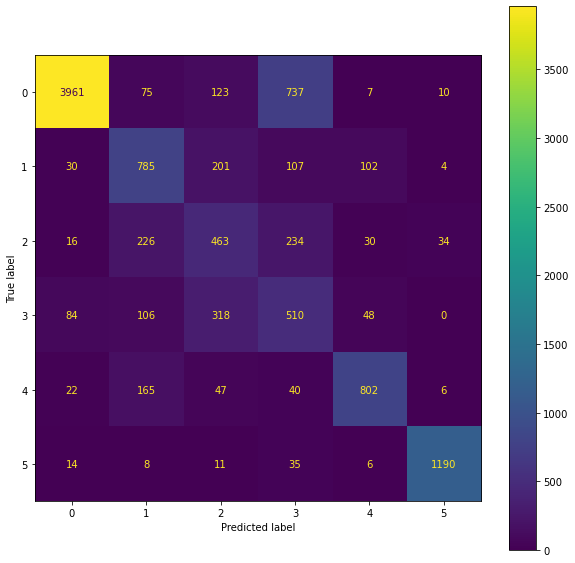

In [20]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [21]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598]


## DNN w/ ZC/SSC/WL + RMS

In [22]:
feature_set = ["zc", "ssc", "wl", "rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 8) y_train shape: (24200,)
X_test shape: (10557, 8) y_test shape: (10557,)


In [23]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 5ms/step - loss: 1.2038 - accuracy: 0.5660 - val_loss: 0.6889 - val_accuracy: 0.7358
Epoch 2/30
387/387 [==============================] - 2s 6ms/step - loss: 1.0123 - accuracy: 0.6252 - val_loss: 0.7119 - val_accuracy: 0.7306
Epoch 3/30
387/387 [==============================] - 3s 8ms/step - loss: 0.9542 - accuracy: 0.6405 - val_loss: 0.7145 - val_accuracy: 0.7303
Epoch 4/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9286 - accuracy: 0.6495 - val_loss: 0.7459 - val_accuracy: 0.7244
Epoch 5/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8988 - accuracy: 0.6579 - val_loss: 0.7233 - val_accuracy: 0.7287
Epoch 6/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8948 - accuracy: 0.6533 - val_loss: 0.6783 - val_accuracy: 0.7416
Epoch 7/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8768 - accuracy: 0.6599 - val_loss: 0.6687 - val_accuracy: 0.7443
Epoch 

Test Accuracy: 0.7550440466041489 Balanced Test Accuracy: 0.6844727160795488
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      4913
           1       0.60      0.63      0.62      1229
           2       0.41      0.50      0.45      1003
           3       0.36      0.44      0.40      1066
           4       0.81      0.72      0.76      1082
           5       0.92      0.95      0.93      1264

    accuracy                           0.76     10557
   macro avg       0.67      0.68      0.68     10557
weighted avg       0.78      0.76      0.77     10557



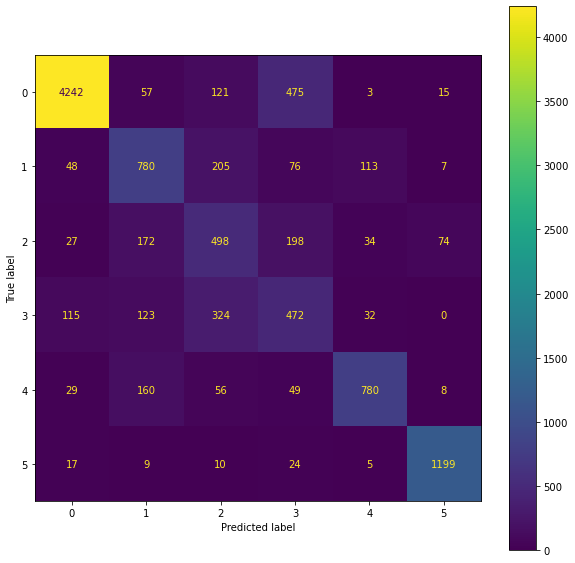

In [24]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [25]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488]


## DNN w/ ZC/SSC/WL + VAR

In [26]:
feature_set = ["zc", "ssc", "wl", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 8) y_train shape: (24200,)
X_test shape: (10557, 8) y_test shape: (10557,)


In [27]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 6ms/step - loss: 1.1276 - accuracy: 0.5828 - val_loss: 0.7436 - val_accuracy: 0.7198
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9580 - accuracy: 0.6385 - val_loss: 0.7612 - val_accuracy: 0.7093
Epoch 3/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9296 - accuracy: 0.6450 - val_loss: 0.6991 - val_accuracy: 0.7336
Epoch 4/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8930 - accuracy: 0.6591 - val_loss: 0.7243 - val_accuracy: 0.7272
Epoch 5/30
387/387 [==============================] - 3s 8ms/step - loss: 0.8870 - accuracy: 0.6576 - val_loss: 0.7083 - val_accuracy: 0.7308
Epoch 6/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8759 - accuracy: 0.6592 - val_loss: 0.6858 - val_accuracy: 0.7421
Epoch 7/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8615 - accuracy: 0.6656 - val_loss: 0.6716 - val_accuracy: 0.7490
Epoch 

Test Accuracy: 0.7548545988443687 Balanced Test Accuracy: 0.6785722348465918
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4913
           1       0.59      0.56      0.57      1229
           2       0.37      0.48      0.42      1003
           3       0.40      0.42      0.41      1066
           4       0.77      0.78      0.78      1082
           5       0.92      0.95      0.94      1264

    accuracy                           0.75     10557
   macro avg       0.67      0.68      0.67     10557
weighted avg       0.77      0.75      0.76     10557



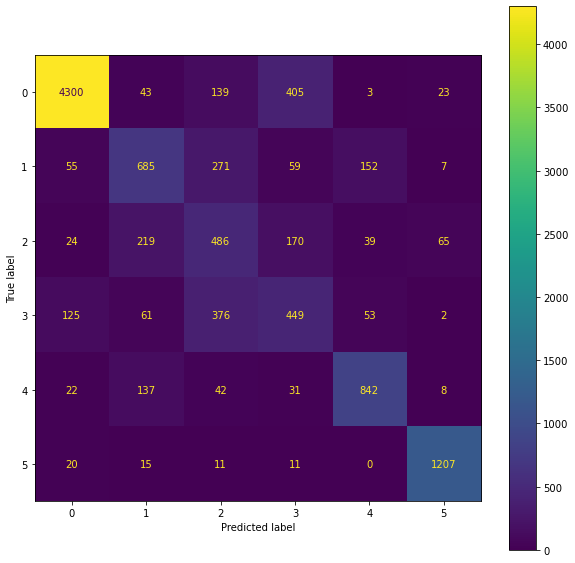

In [28]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [29]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918]


## DNN w/ ZC/SSC/WL + MAV + RMS

In [30]:
feature_set = ["zc", "ssc", "wl", "mav", "rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 10) y_train shape: (24200,)
X_test shape: (10557, 10) y_test shape: (10557,)


In [31]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 5ms/step - loss: 1.2411 - accuracy: 0.5587 - val_loss: 0.7109 - val_accuracy: 0.7463
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 1.0117 - accuracy: 0.6226 - val_loss: 0.7267 - val_accuracy: 0.7371
Epoch 3/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9610 - accuracy: 0.6388 - val_loss: 0.7086 - val_accuracy: 0.7383
Epoch 4/30
387/387 [==============================] - 3s 8ms/step - loss: 0.9331 - accuracy: 0.6447 - val_loss: 0.7097 - val_accuracy: 0.7414
Epoch 5/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9145 - accuracy: 0.6491 - val_loss: 0.7075 - val_accuracy: 0.7399
Epoch 6/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8869 - accuracy: 0.6599 - val_loss: 0.6992 - val_accuracy: 0.7446
Epoch 7/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8704 - accuracy: 0.6644 - val_loss: 0.7007 - val_accuracy: 0.7447
Epoch 

Test Accuracy: 0.7705787629061286 Balanced Test Accuracy: 0.7013752069789124
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      4913
           1       0.56      0.68      0.62      1229
           2       0.43      0.49      0.46      1003
           3       0.41      0.46      0.44      1066
           4       0.83      0.74      0.78      1082
           5       0.96      0.95      0.95      1264

    accuracy                           0.77     10557
   macro avg       0.69      0.70      0.69     10557
weighted avg       0.79      0.77      0.78     10557



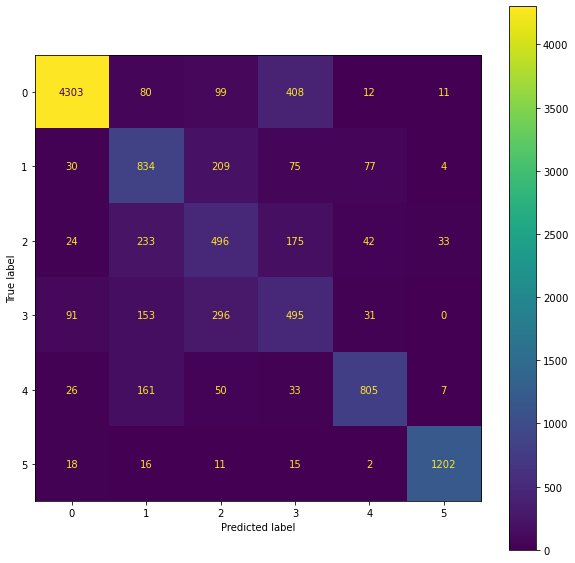

In [32]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [33]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124]


## DNN w/ ZC/SSC/WL + MAV + VAR

In [34]:
feature_set = ["zc", "ssc", "wl", "mav", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 10) y_train shape: (24200,)
X_test shape: (10557, 10) y_test shape: (10557,)


In [35]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 6ms/step - loss: 1.1956 - accuracy: 0.5642 - val_loss: 0.7290 - val_accuracy: 0.7320
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9757 - accuracy: 0.6345 - val_loss: 0.7048 - val_accuracy: 0.7393
Epoch 3/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9375 - accuracy: 0.6451 - val_loss: 0.6963 - val_accuracy: 0.7399
Epoch 4/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9151 - accuracy: 0.6480 - val_loss: 0.7010 - val_accuracy: 0.7356
Epoch 5/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8910 - accuracy: 0.6582 - val_loss: 0.6984 - val_accuracy: 0.7369
Epoch 6/30
387/387 [==============================] - 3s 8ms/step - loss: 0.8793 - accuracy: 0.6638 - val_loss: 0.6629 - val_accuracy: 0.7510
Epoch 7/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8551 - accuracy: 0.6667 - val_loss: 0.7194 - val_accuracy: 0.7267
Epoch 

Test Accuracy: 0.7671687032300843 Balanced Test Accuracy: 0.6974564101474835
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4913
           1       0.58      0.63      0.60      1229
           2       0.43      0.56      0.49      1003
           3       0.40      0.42      0.41      1066
           4       0.80      0.76      0.78      1082
           5       0.96      0.94      0.95      1264

    accuracy                           0.77     10557
   macro avg       0.69      0.70      0.69     10557
weighted avg       0.79      0.77      0.78     10557



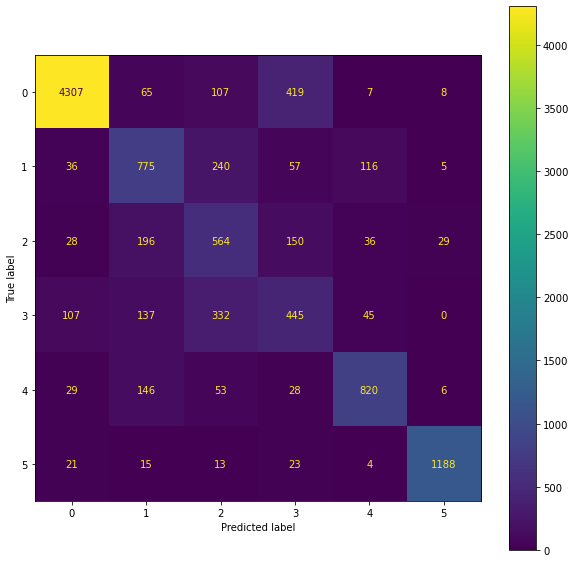

In [36]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [37]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835]


## DNN w/ ZC/SSC/WL + RMS + VAR

In [38]:
feature_set = ["zc", "ssc", "wl", "rms", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 10) y_train shape: (24200,)
X_test shape: (10557, 10) y_test shape: (10557,)


In [39]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 6ms/step - loss: 1.2314 - accuracy: 0.5568 - val_loss: 0.7448 - val_accuracy: 0.7469
Epoch 2/30
387/387 [==============================] - 2s 6ms/step - loss: 1.0008 - accuracy: 0.6316 - val_loss: 0.7542 - val_accuracy: 0.7388
Epoch 3/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9476 - accuracy: 0.6393 - val_loss: 0.7110 - val_accuracy: 0.7439
Epoch 4/30
387/387 [==============================] - 3s 6ms/step - loss: 0.9236 - accuracy: 0.6482 - val_loss: 0.7355 - val_accuracy: 0.7369
Epoch 5/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8844 - accuracy: 0.6593 - val_loss: 0.7358 - val_accuracy: 0.7305
Epoch 6/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8845 - accuracy: 0.6636 - val_loss: 0.7155 - val_accuracy: 0.7372
Epoch 7/30
387/387 [==============================] - 3s 8ms/step - loss: 0.8565 - accuracy: 0.6754 - val_loss: 0.7328 - val_accuracy: 0.7313
Epoch 

Test Accuracy: 0.7658425689116226 Balanced Test Accuracy: 0.6996378600655317
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      4913
           1       0.60      0.62      0.61      1229
           2       0.42      0.56      0.48      1003
           3       0.40      0.43      0.41      1066
           4       0.78      0.78      0.78      1082
           5       0.94      0.95      0.95      1264

    accuracy                           0.77     10557
   macro avg       0.68      0.70      0.69     10557
weighted avg       0.79      0.77      0.77     10557



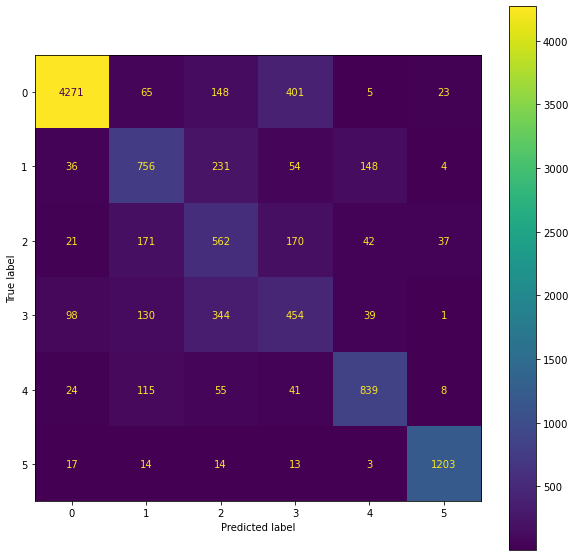

In [40]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [41]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843, 0.7658425689116226] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835, 0.6996378600655317]


## DNN w/ ZC/SSC/WL + MAV + RMS + VAR

In [42]:
feature_set = ["zc", "ssc", "wl", "mav", "rms", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 12) y_train shape: (24200,)
X_test shape: (10557, 12) y_test shape: (10557,)


In [43]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 6ms/step - loss: 1.1945 - accuracy: 0.5646 - val_loss: 0.7229 - val_accuracy: 0.7370
Epoch 2/30
387/387 [==============================] - 3s 7ms/step - loss: 0.9921 - accuracy: 0.6324 - val_loss: 0.6953 - val_accuracy: 0.7366
Epoch 3/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9495 - accuracy: 0.6413 - val_loss: 0.6823 - val_accuracy: 0.7418
Epoch 4/30
387/387 [==============================] - 3s 8ms/step - loss: 0.9030 - accuracy: 0.6533 - val_loss: 0.7117 - val_accuracy: 0.7352
Epoch 5/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9059 - accuracy: 0.6555 - val_loss: 0.6974 - val_accuracy: 0.7407
Epoch 6/30
387/387 [==============================] - 2s 5ms/step - loss: 0.8719 - accuracy: 0.6637 - val_loss: 0.6981 - val_accuracy: 0.7412
Epoch 7/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8664 - accuracy: 0.6667 - val_loss: 0.7661 - val_accuracy: 0.7228
Epoch 

Test Accuracy: 0.7808089419342616 Balanced Test Accuracy: 0.7107841377674059
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      4913
           1       0.64      0.66      0.65      1229
           2       0.43      0.51      0.46      1003
           3       0.43      0.47      0.45      1066
           4       0.79      0.79      0.79      1082
           5       0.94      0.95      0.95      1264

    accuracy                           0.78     10557
   macro avg       0.70      0.71      0.70     10557
weighted avg       0.80      0.78      0.79     10557



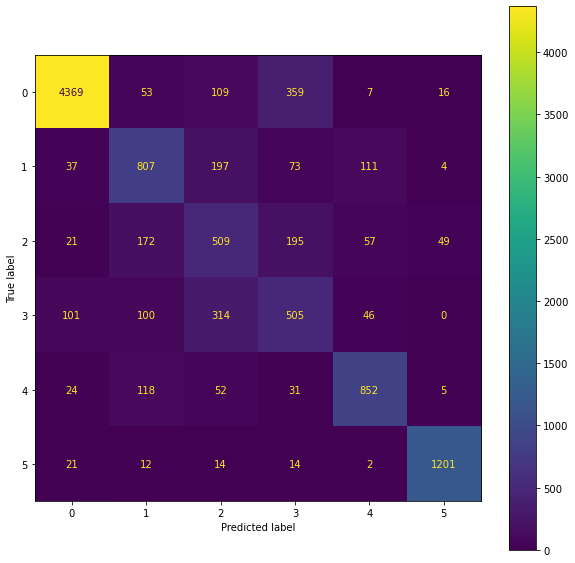

In [44]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [45]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843, 0.7658425689116226, 0.7808089419342616] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835, 0.6996378600655317, 0.7107841377674059]


## DNN w/ ZC/SSC/WL + iEMG + VAR + WAMP (Du)

In [46]:
feature_set = ["zc", "ssc", "wl", "iemg", "var", "wamp"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 12) y_train shape: (24200,)
X_test shape: (10557, 12) y_test shape: (10557,)


In [47]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 6ms/step - loss: 1.1935 - accuracy: 0.5665 - val_loss: 0.7342 - val_accuracy: 0.7436
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9770 - accuracy: 0.6343 - val_loss: 0.6829 - val_accuracy: 0.7468
Epoch 3/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9402 - accuracy: 0.6421 - val_loss: 0.7182 - val_accuracy: 0.7383
Epoch 4/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9138 - accuracy: 0.6558 - val_loss: 0.6824 - val_accuracy: 0.7457
Epoch 5/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8985 - accuracy: 0.6589 - val_loss: 0.6792 - val_accuracy: 0.7497
Epoch 6/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8711 - accuracy: 0.6671 - val_loss: 0.6921 - val_accuracy: 0.7448
Epoch 7/30
387/387 [==============================] - 3s 7ms/step - loss: 0.8523 - accuracy: 0.6683 - val_loss: 0.6952 - val_accuracy: 0.7476
Epoch 

Test Accuracy: 0.7509709197688738 Balanced Test Accuracy: 0.6919768939077993
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      4913
           1       0.58      0.65      0.62      1229
           2       0.40      0.50      0.44      1003
           3       0.36      0.44      0.39      1066
           4       0.81      0.78      0.79      1082
           5       0.94      0.95      0.94      1264

    accuracy                           0.75     10557
   macro avg       0.67      0.69      0.68     10557
weighted avg       0.78      0.75      0.76     10557



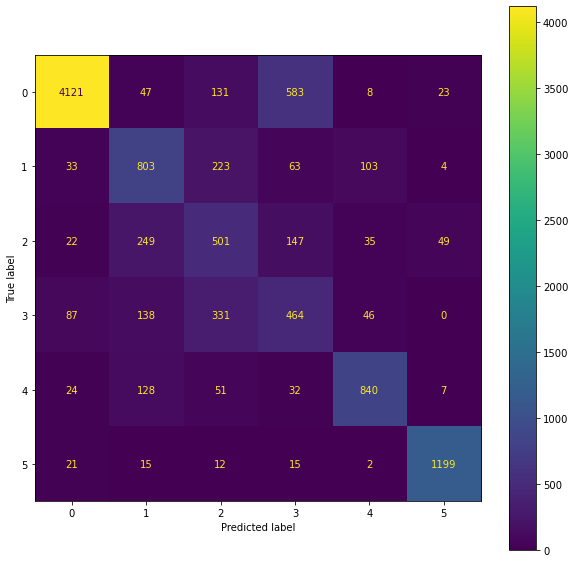

In [48]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [49]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843, 0.7658425689116226, 0.7808089419342616, 0.7509709197688738] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835, 0.6996378600655317, 0.7107841377674059, 0.6919768939077993]


## DNN w/ Skewness/RMS/iEMG/AR(P=11) + Hjorth

In [50]:
feature_set = ["skewness", "rms", "iemg", "ar_coeff", "hjorth"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 34) y_train shape: (24200,)
X_test shape: (10557, 34) y_test shape: (10557,)


In [51]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 5ms/step - loss: 1.4459 - accuracy: 0.4913 - val_loss: 0.7029 - val_accuracy: 0.7571
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 1.0969 - accuracy: 0.6050 - val_loss: 0.6641 - val_accuracy: 0.7684
Epoch 3/30
387/387 [==============================] - 2s 6ms/step - loss: 0.9776 - accuracy: 0.6435 - val_loss: 0.6407 - val_accuracy: 0.7770
Epoch 4/30
387/387 [==============================] - 3s 9ms/step - loss: 0.9273 - accuracy: 0.6621 - val_loss: 0.6288 - val_accuracy: 0.7801
Epoch 5/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8792 - accuracy: 0.6796 - val_loss: 0.6183 - val_accuracy: 0.7836
Epoch 6/30
387/387 [==============================] - 2s 5ms/step - loss: 0.8347 - accuracy: 0.6960 - val_loss: 0.6095 - val_accuracy: 0.7877
Epoch 7/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8264 - accuracy: 0.6937 - val_loss: 0.6091 - val_accuracy: 0.7862
Epoch 

Test Accuracy: 0.8109311357393199 Balanced Test Accuracy: 0.7666575280557005
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4913
           1       0.73      0.73      0.73      1229
           2       0.52      0.60      0.55      1003
           3       0.53      0.60      0.56      1066
           4       0.79      0.85      0.82      1082
           5       0.96      0.94      0.95      1264

    accuracy                           0.81     10557
   macro avg       0.75      0.77      0.75     10557
weighted avg       0.82      0.81      0.82     10557



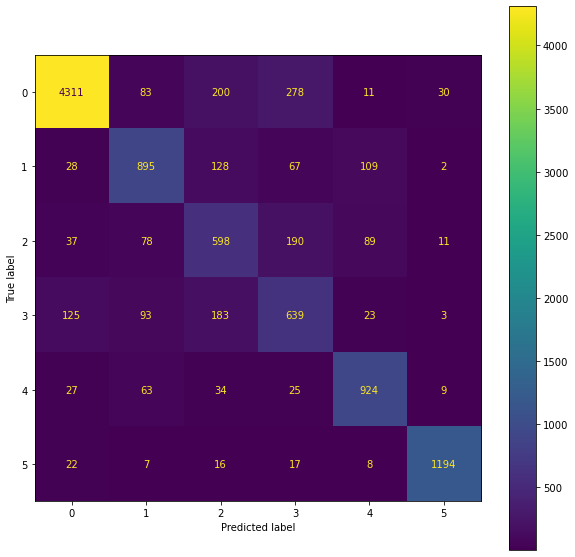

In [52]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [53]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843, 0.7658425689116226, 0.7808089419342616, 0.7509709197688738, 0.8109311357393199] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835, 0.6996378600655317, 0.7107841377674059, 0.6919768939077993, 0.7666575280557005]


## DNN w/ Frequency Domain Features (MNF/MDF/MMNF/MMDF)

In [16]:
feature_set = ["mnf", "mdf", "mmnf", "mmdf"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride, False)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 8) y_train shape: (24200,)
X_test shape: (10557, 8) y_test shape: (10557,)


In [17]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 4s 7ms/step - loss: 1.6144 - accuracy: 0.4330 - val_loss: 0.9920 - val_accuracy: 0.6351
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 1.3309 - accuracy: 0.5126 - val_loss: 0.9204 - val_accuracy: 0.6652
Epoch 3/30
387/387 [==============================] - 3s 7ms/step - loss: 1.2732 - accuracy: 0.5281 - val_loss: 0.8994 - val_accuracy: 0.6701
Epoch 4/30
387/387 [==============================] - 2s 6ms/step - loss: 1.1998 - accuracy: 0.5489 - val_loss: 0.9005 - val_accuracy: 0.6690
Epoch 5/30
387/387 [==============================] - 2s 5ms/step - loss: 1.1828 - accuracy: 0.5578 - val_loss: 0.9044 - val_accuracy: 0.6702
Epoch 6/30
387/387 [==============================] - 2s 5ms/step - loss: 1.1520 - accuracy: 0.5647 - val_loss: 0.8735 - val_accuracy: 0.6780
Epoch 7/30
387/387 [==============================] - 2s 5ms/step - loss: 1.1351 - accuracy: 0.5694 - val_loss: 0.8813 - val_accuracy: 0.6749
Epoch 

Test Accuracy: 0.6973572037510657 Balanced Test Accuracy: 0.6228988904286735
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4913
           1       0.53      0.56      0.55      1229
           2       0.29      0.37      0.33      1003
           3       0.35      0.38      0.36      1066
           4       0.65      0.73      0.69      1082
           5       0.83      0.88      0.86      1264

    accuracy                           0.70     10557
   macro avg       0.60      0.62      0.61     10557
weighted avg       0.72      0.70      0.71     10557



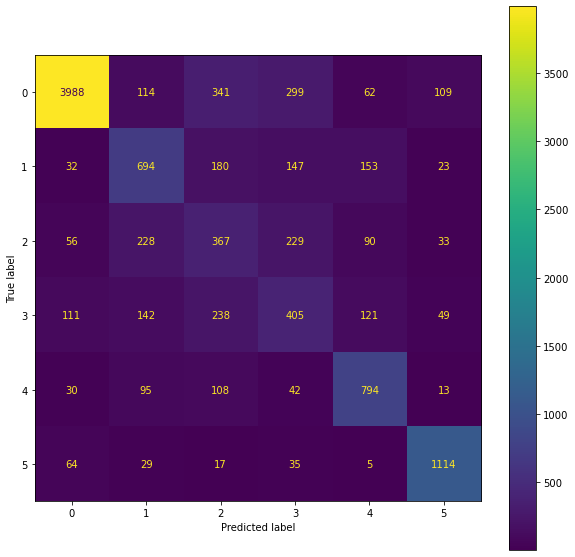

In [18]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [19]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth'], ['mnf', 'mdf', 'mmnf', 'mmdf']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843, 0.7658425689116226, 0.7808089419342616, 0.7509709197688738, 0.8109311357393199, 0.6973572037510657] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835, 0.6996378600655317, 0.7107841377674059, 0.6919768939077993, 0.7666575280557005, 0.6228988904286735]


## DNN w/ MNF/MDF

In [20]:
feature_set = ["mnf", "mdf"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride, False)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 4) y_train shape: (24200,)
X_test shape: (10557, 4) y_test shape: (10557,)


In [21]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 5ms/step - loss: 1.7007 - accuracy: 0.3855 - val_loss: 1.1622 - val_accuracy: 0.5619
Epoch 2/30
387/387 [==============================] - 2s 6ms/step - loss: 1.5195 - accuracy: 0.4385 - val_loss: 1.1250 - val_accuracy: 0.5848
Epoch 3/30
387/387 [==============================] - 3s 8ms/step - loss: 1.4492 - accuracy: 0.4631 - val_loss: 1.1050 - val_accuracy: 0.5926
Epoch 4/30
387/387 [==============================] - 2s 5ms/step - loss: 1.4095 - accuracy: 0.4666 - val_loss: 1.1139 - val_accuracy: 0.5880
Epoch 5/30
387/387 [==============================] - 2s 5ms/step - loss: 1.3884 - accuracy: 0.4690 - val_loss: 1.0904 - val_accuracy: 0.6083
Epoch 6/30
387/387 [==============================] - 2s 6ms/step - loss: 1.3544 - accuracy: 0.4806 - val_loss: 1.1027 - val_accuracy: 0.5868
Epoch 7/30
387/387 [==============================] - 3s 8ms/step - loss: 1.3478 - accuracy: 0.4802 - val_loss: 1.1058 - val_accuracy: 0.5863
Epoch 

Test Accuracy: 0.6194941744813868 Balanced Test Accuracy: 0.5361518384530704
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      4913
           1       0.43      0.58      0.49      1229
           2       0.25      0.27      0.26      1003
           3       0.27      0.23      0.25      1066
           4       0.58      0.61      0.59      1082
           5       0.61      0.78      0.69      1264

    accuracy                           0.62     10557
   macro avg       0.50      0.54      0.51     10557
weighted avg       0.65      0.62      0.63     10557



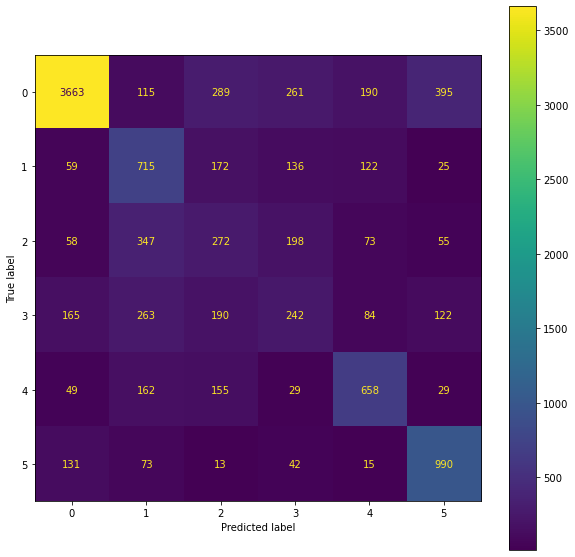

In [22]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [23]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth'], ['mnf', 'mdf', 'mmnf', 'mmdf'], ['mnf', 'mdf']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843, 0.7658425689116226, 0.7808089419342616, 0.7509709197688738, 0.8109311357393199, 0.6973572037510657, 0.6194941744813868] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835, 0.6996378600655317, 0.7107841377674059, 0.6919768939077993, 0.7666575280557005, 0.6228988904286735, 0.5361518384530704]


## DNN w/ MMNF/MMDF

In [25]:
feature_set = ["mmnf", "mmdf"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride, False)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 4) y_train shape: (24200,)
X_test shape: (10557, 4) y_test shape: (10557,)


In [26]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 5ms/step - loss: 1.7454 - accuracy: 0.3625 - val_loss: 1.3296 - val_accuracy: 0.4695
Epoch 2/30
387/387 [==============================] - 2s 5ms/step - loss: 1.5397 - accuracy: 0.4201 - val_loss: 1.2704 - val_accuracy: 0.4960
Epoch 3/30
387/387 [==============================] - 2s 5ms/step - loss: 1.4883 - accuracy: 0.4294 - val_loss: 1.2219 - val_accuracy: 0.5180
Epoch 4/30
387/387 [==============================] - 2s 5ms/step - loss: 1.4636 - accuracy: 0.4302 - val_loss: 1.2597 - val_accuracy: 0.4998
Epoch 5/30
387/387 [==============================] - 3s 8ms/step - loss: 1.4276 - accuracy: 0.4409 - val_loss: 1.2536 - val_accuracy: 0.5076
Epoch 6/30
387/387 [==============================] - 3s 8ms/step - loss: 1.4093 - accuracy: 0.4461 - val_loss: 1.2350 - val_accuracy: 0.5040
Epoch 7/30
387/387 [==============================] - 3s 7ms/step - loss: 1.4001 - accuracy: 0.4471 - val_loss: 1.2655 - val_accuracy: 0.4934
Epoch 

Test Accuracy: 0.5370843989769821 Balanced Test Accuracy: 0.4798218658786255
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      4913
           1       0.35      0.48      0.40      1229
           2       0.19      0.23      0.21      1003
           3       0.26      0.30      0.28      1066
           4       0.44      0.54      0.49      1082
           5       0.56      0.72      0.63      1264

    accuracy                           0.54     10557
   macro avg       0.44      0.48      0.45     10557
weighted avg       0.60      0.54      0.56     10557



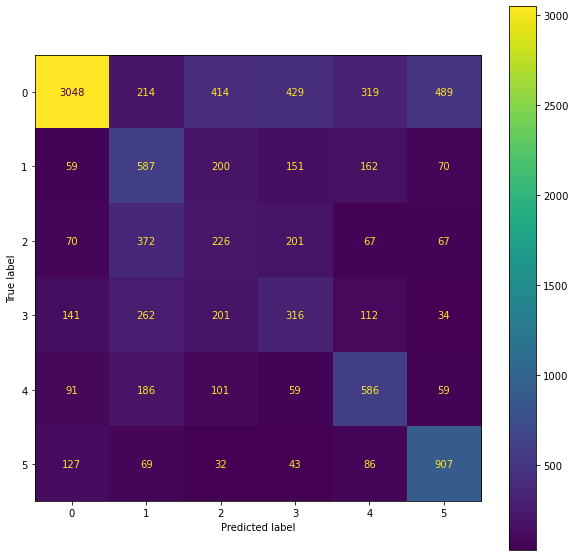

In [27]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [28]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth'], ['mnf', 'mdf', 'mmnf', 'mmdf'], ['mnf', 'mdf'], ['mmnf', 'mmdf']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843, 0.7658425689116226, 0.7808089419342616, 0.7509709197688738, 0.8109311357393199, 0.6973572037510657, 0.6194941744813868, 0.5370843989769821] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835, 0.6996378600655317, 0.7107841377674059, 0.6919768939077993, 0.7666575280557005, 0.6228988904286735, 0.5361518384530704, 0.4798218658786255]


## DNN w/ Skewness/RMS/iEMG/AR(P=11) + Hjorth + MAV + ZC/SSC/WL

In [40]:
feature_set = ["skewness", "rms", "iemg", "ar_coeff", "hjorth", "mav", "zc", "ssc", "wl"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (24200, 42) y_train shape: (24200,)
X_test shape: (10557, 42) y_test shape: (10557,)


In [41]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
387/387 [==============================] - 3s 6ms/step - loss: 1.3677 - accuracy: 0.5094 - val_loss: 0.7121 - val_accuracy: 0.7382
Epoch 2/30
387/387 [==============================] - 3s 8ms/step - loss: 1.0238 - accuracy: 0.6264 - val_loss: 0.6541 - val_accuracy: 0.7608
Epoch 3/30
387/387 [==============================] - 2s 5ms/step - loss: 0.9349 - accuracy: 0.6609 - val_loss: 0.6479 - val_accuracy: 0.7616
Epoch 4/30
387/387 [==============================] - 2s 5ms/step - loss: 0.8729 - accuracy: 0.6786 - val_loss: 0.6271 - val_accuracy: 0.7702
Epoch 5/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8363 - accuracy: 0.6887 - val_loss: 0.6144 - val_accuracy: 0.7745
Epoch 6/30
387/387 [==============================] - 2s 6ms/step - loss: 0.8069 - accuracy: 0.6991 - val_loss: 0.6112 - val_accuracy: 0.7784
Epoch 7/30
387/387 [==============================] - 3s 7ms/step - loss: 0.7797 - accuracy: 0.7095 - val_loss: 0.5999 - val_accuracy: 0.7823
Epoch 

Test Accuracy: 0.8159515013734963 Balanced Test Accuracy: 0.7761064980227994
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      4913
           1       0.73      0.77      0.75      1229
           2       0.53      0.60      0.56      1003
           3       0.51      0.63      0.57      1066
           4       0.82      0.84      0.83      1082
           5       0.97      0.95      0.96      1264

    accuracy                           0.82     10557
   macro avg       0.75      0.78      0.76     10557
weighted avg       0.83      0.82      0.82     10557



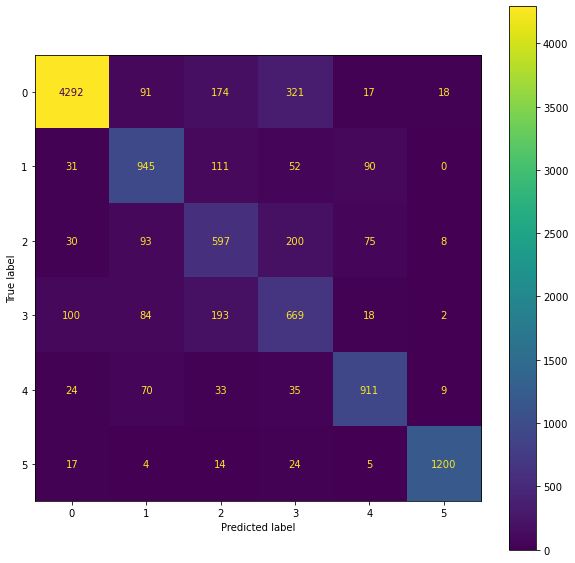

In [42]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [43]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth'], ['mnf', 'mdf', 'mmnf', 'mmdf'], ['mnf', 'mdf'], ['mmnf', 'mmdf'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth', 'mav', 'zc', 'ssc', 'wl']] [0.6594676517950175, 0.7309841811120583, 0.7304158378327176, 0.7550440466041489, 0.7548545988443687, 0.7705787629061286, 0.7671687032300843, 0.7658425689116226, 0.7808089419342616, 0.7509709197688738, 0.8109311357393199, 0.6973572037510657, 0.6194941744813868, 0.5370843989769821, 0.8159515013734963] [0.6234662185865222, 0.6465196341355128, 0.6779456463046598, 0.6844727160795488, 0.6785722348465918, 0.7013752069789124, 0.6974564101474835, 0.6996378600655317, 0.7107841377674059, 0.6919768939077993

In [44]:
np.save("feature_sets", np.array(feature_sets))
np.save("accuracies", np.array(accuracies))
np.save("balanced_accuracies", np.array(balanced_accuracies))

In [ ]:
feature_sets = np.load("feature_sets.npy", allow_pickle=True).tolist()
accuracies = np.load("accuracies.npy", allow_pickle=True).tolist()
balanced_accuracies = np.load("balanced_accuracies.npy", allow_pickle=True).tolist()

## Feature Sets Accuracies

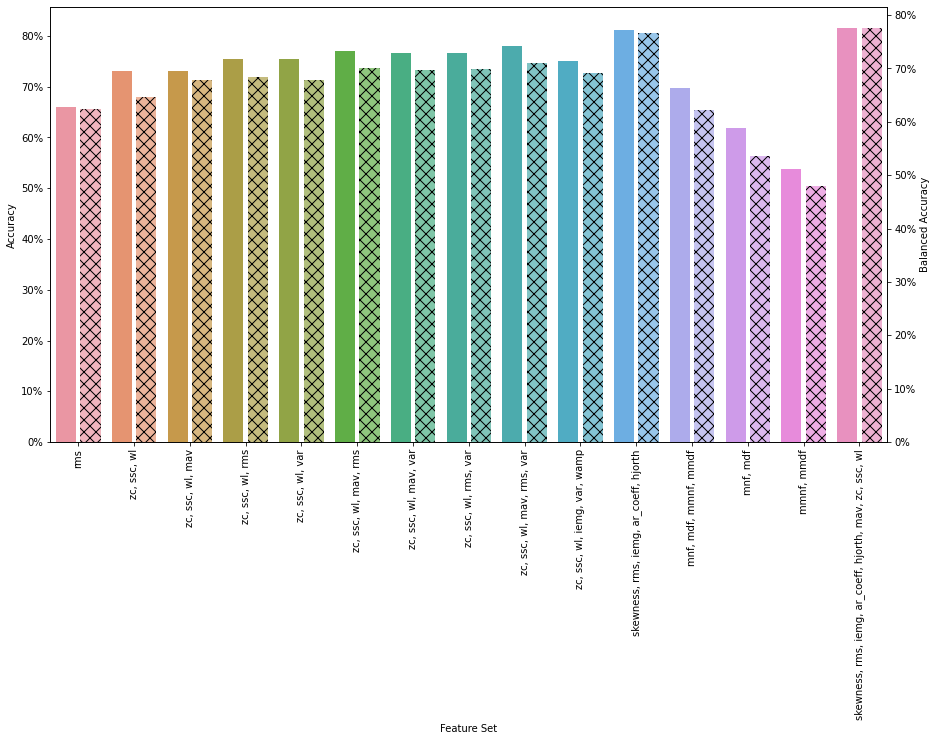

In [45]:
from matplotlib.ticker import PercentFormatter

results = pd.DataFrame({
    'Feature Set': [", ".join(ft) for ft in feature_sets],
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies
})

data1 = results[['Feature Set', 'Accuracy']]
data2 = results[['Feature Set', 'Balanced Accuracy']]

plt.figure(figsize=(15, 8))
width_scale = 0.45

ax = sns.barplot(x='Feature Set', y='Accuracy', data=data1)
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)

ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='x', rotation=90)

ax2 = ax.twinx()
sns.barplot(x='Feature Set', y='Balanced Accuracy', data=data2, alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.tick_params(axis='x', rotation=90)

plt.show()

In [47]:
for fs, acc, bal_acc in zip(feature_sets, accuracies, balanced_accuracies):
    print("Feature Set: {0}   Accuracy: {1}   Balanced Accuracy: {2}".format(",".join(fs), acc*100, bal_acc*100))

Feature Set: rms   Accuracy: 65.94676517950175   Balanced Accuracy: 62.34662185865222
Feature Set: zc,ssc,wl   Accuracy: 73.09841811120583   Balanced Accuracy: 64.65196341355129
Feature Set: zc,ssc,wl,mav   Accuracy: 73.04158378327176   Balanced Accuracy: 67.79456463046598
Feature Set: zc,ssc,wl,rms   Accuracy: 75.50440466041489   Balanced Accuracy: 68.44727160795489
Feature Set: zc,ssc,wl,var   Accuracy: 75.48545988443686   Balanced Accuracy: 67.85722348465917
Feature Set: zc,ssc,wl,mav,rms   Accuracy: 77.05787629061285   Balanced Accuracy: 70.13752069789125
Feature Set: zc,ssc,wl,mav,var   Accuracy: 76.71687032300844   Balanced Accuracy: 69.74564101474834
Feature Set: zc,ssc,wl,rms,var   Accuracy: 76.58425689116225   Balanced Accuracy: 69.96378600655318
Feature Set: zc,ssc,wl,mav,rms,var   Accuracy: 78.08089419342616   Balanced Accuracy: 71.07841377674059
Feature Set: zc,ssc,wl,iemg,var,wamp   Accuracy: 75.09709197688737   Balanced Accuracy: 69.19768939077993
Feature Set: skewness,rm

## DNN w/ Skewness/RMS/iEMG/AR(P=11) + Hjorth + MAV + ZC/SSC/WL Tuning

In [48]:
import keras_tuner as kt

In [64]:
feature_set = ["skewness", "rms", "iemg", "ar_coeff", "hjorth", "mav", "zc", "ssc", "wl"]
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)

X_train shape: (24200, 42) y_train shape: (24200,)
X_test shape: (10557, 42) y_test shape: (10557,)


In [65]:
def model_builder(hp):
    model = keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
    model.add(layers.BatchNormalization())
    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)
    model.add(layers.Dropout(hp_dropout1))
    
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
    model.add(layers.BatchNormalization())
    hp_dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.9, step=0.1)
    model.add(layers.Dropout(hp_dropout2))
    
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units3, activation='relu'))
    model.add(layers.BatchNormalization())
    hp_dropout3 = hp.Float('dropout3', min_value=0.1, max_value=0.9, step=0.1)
    model.add(layers.Dropout(hp_dropout3))
    
    model.add(layers.Dense(6, activation="softmax"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [69]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuned_model',
                     project_name='biosignal_analysis')

In [70]:
import tensorflow as tf

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [71]:
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Optimal number of units in the 1st densely-connected layer: {best_hps.get('units1')} 
Optimal number of units in the 2nd densely-connected layer: {best_hps.get('units2')}
Optimal number of units in the 3rd densely-connected layer: {best_hps.get('units3')}

Optimal dropout rate in the 1st densely-connected layer: {best_hps.get('dropout1')} 
Optimal dropout rate in the 2nd densely-connected layer: {best_hps.get('dropout2')}
Optimal dropout rate in the 3rd densely-connected layer: {best_hps.get('dropout3')}

Optimal learning rate for the optimizer: {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.758578896522522

Best val_accuracy So Far: 0.8130803108215332
Total elapsed time: 00h 03m 08s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
Optimal number of units in the 1st densely-connected layer: 320 
Optimal number of units in the 2nd densely-connected layer: 256
Optimal number of units in the 3rd densely-connected layer: 448

Optimal dropout rate in the 1st densely-connected layer: 0.4 
Optimal dropout rate in the 2nd densely-connected layer: 0.7000000000000001
Optimal dropout rate in the 3rd densely-connected layer: 0.1

Optimal learning rate for the optimizer: 0.01.



In [72]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
310/310 [==============================] - 2s 5ms/step - loss: 1.1562 - accuracy: 0.5915 - val_loss: 0.8258 - val_accuracy: 0.7154
Epoch 2/50
310/310 [==============================] - 1s 5ms/step - loss: 0.8806 - accuracy: 0.6789 - val_loss: 0.7450 - val_accuracy: 0.7380
Epoch 3/50
310/310 [==============================] - 1s 5ms/step - loss: 0.8021 - accuracy: 0.7089 - val_loss: 0.6282 - val_accuracy: 0.7679
Epoch 4/50
310/310 [==============================] - 1s 5ms/step - loss: 0.7558 - accuracy: 0.7244 - val_loss: 0.5869 - val_accuracy: 0.7925
Epoch 5/50
310/310 [==============================] - 1s 5ms/step - loss: 0.7212 - accuracy: 0.7380 - val_loss: 0.5773 - val_accuracy: 0.7949
Epoch 6/50
310/310 [==============================] - 1s 5ms/step - loss: 0.7163 - accuracy: 0.7414 - val_loss: 0.5717 - val_accuracy: 0.7905
Epoch 7/50
310/310 [==============================] - 1s 5ms/step - loss: 0.6913 - accuracy: 0.7505 - val_loss: 0.5942 - val_accuracy: 0.7683
Epoch 

In [73]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train_scaled, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/40
310/310 [==============================] - 2s 5ms/step - loss: 1.1384 - accuracy: 0.6078 - val_loss: 0.8649 - val_accuracy: 0.6895
Epoch 2/40
310/310 [==============================] - 1s 5ms/step - loss: 0.8765 - accuracy: 0.6803 - val_loss: 0.7196 - val_accuracy: 0.7529
Epoch 3/40
310/310 [==============================] - 1s 5ms/step - loss: 0.8035 - accuracy: 0.7102 - val_loss: 0.6847 - val_accuracy: 0.7626
Epoch 4/40
310/310 [==============================] - 1s 5ms/step - loss: 0.7587 - accuracy: 0.7240 - val_loss: 0.6393 - val_accuracy: 0.7533
Epoch 5/40
310/310 [==============================] - 1s 5ms/step - loss: 0.7264 - accuracy: 0.7354 - val_loss: 0.5915 - val_accuracy: 0.7933
Epoch 6/40
310/310 [==============================] - 2s 5ms/step - loss: 0.7160 - accuracy: 0.7424 - val_loss: 0.5768 - val_accuracy: 0.7872
Epoch 7/40
310/310 [==============================] - 2s 5ms/step - loss: 0.6915 - accuracy: 0.7507 - val_loss: 0.5797 - val_accuracy: 0.7949
Epoch 

Test Accuracy: 0.8348962773515203 Balanced Test Accuracy: 0.7876595027315365
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4913
           1       0.84      0.73      0.78      1229
           2       0.60      0.59      0.59      1003
           3       0.56      0.67      0.61      1066
           4       0.75      0.88      0.81      1082
           5       0.95      0.95      0.95      1264

    accuracy                           0.83     10557
   macro avg       0.77      0.79      0.78     10557
weighted avg       0.84      0.83      0.84     10557



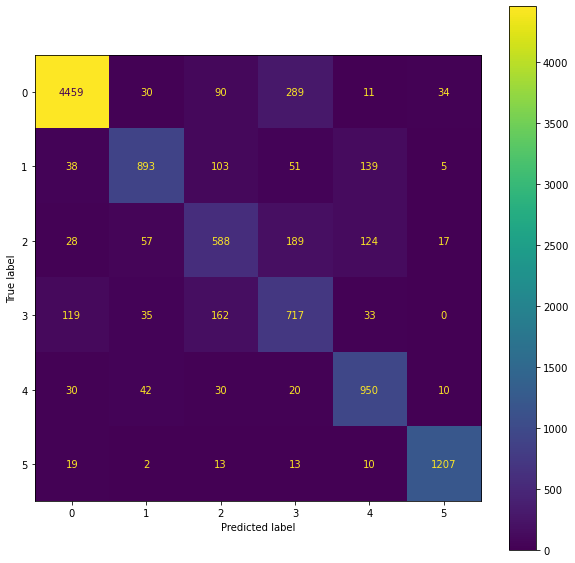

In [74]:
predictions = hypermodel.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)